# Module 6 – Software Engineering

This notebook outlines how I created a model that predicts the number of incidents at a location based on the time of day, site conditions, and location. Throughout this notebook, you will see exploratory data analysis, data transformation, data visualization, data splitting, and model creation.

This code is being changd into OOP please could you show wherte OOP should be sued and not.

In [596]:
# Import the pandas library for data manipulation and analysis 
import pandas as pd
# Import Plotly Express for creating interactive visualizations
import plotly.express as px
# Import Folium for creating interactive maps using Leaflet.js
import folium
# Import KMeans clustering algorithm from scikit-learn for unsupervised machine learning
from sklearn.cluster import KMeans
# Import Plotly IO for input/output operations, such as rendering or saving visualizations
import plotly.io as pio
# Import train_test_split function from scikit-learn for splitting datasets into training and testing sets
from sklearn.model_selection import train_test_split
# Import RandomForestRegressor from scikit-learn for building regression models using random forests
from sklearn.ensemble import RandomForestRegressor
# Import mean_squared_error and r2_score from scikit-learn for evaluating regression model performance
from sklearn.metrics import mean_squared_error, r2_score
# Import Matplotlib's pyplot module for creating static, animated, and interactive visualizations
import matplotlib.pyplot as plt
# This allows for category values to be encoded
from sklearn.preprocessing import StandardScaler

In [597]:
class IncidentEDA:
    def __init__(self, df):
        self.df = df

    def show_head(self, n=5):
        return self.df.head(n)
    
    def value_counts(self, column):
        return self.df[column].value_counts()
    
    def info(self):
        return self.df.info()
    
    def describe(self):
        return self.df.describe()
    
    def unique_values(self, column):
        return self.df[column].unique()

In [598]:
class IncidentDataProcessor:
    def __init__(self, file_path):
        self.file_path = file_path
        self.df = None

    def load_data(self):
        self.df = pd.read_csv(self.file_path)
        return self
    
    def get_dataframe(self):
        return self.df
    
    def clean_columns(self):
        self.df = self.df.rename(columns={
            'Informed_Time': 'informed_time',
            'Nature_of_Incident_to_Assess': 'nature_of_incident_to_assess',
            'Incident_Location Latitude': 'incident_location_latitude',
            'Incident_Location Longitude': 'incident_location_longitude',
            'Site_Conditions_Upon_Arrival': 'site_conditions_upon_arrival',
            'Light_Upon_Arrival': 'light_upon_arrival'
        })
        return self
    
    def convert_dates(self):
        self.df['informed_time'] = pd.to_datetime(self.df['informed_time'], errors='coerce')
        return self
    
    def drop_missing(self):
        self.df.dropna(inplace=True)
        return self
    
    def filter_rows_no_br(self, column):
        self.df = self.df[~self.df[column].astype(str).str.contains('<br>', case=False, na=False)]
        return self

    
    def replace_value(self, column, old_value, new_value):
        self.df[column] = self.df[column].replace(old_value, new_value)
        return self
    
    def split_column(self, column, delimiter='<br>'):
        self.df[column] = self.df[column].str.split(delimiter)
        return self
    
    def explode_column(self, column):
        self.df = self.df.explode(column, ignore_index=True)
        return self
    

In [599]:
file_path = 'C:\\Users\\700099\\OneDrive - Amey plc\\Documents\\BPP University\\Module 6 - Software Engineering\\Module 6 - Incident Job Pack Dataset.csv'
processor = IncidentDataProcessor(file_path)
processor.load_data()
processor.clean_columns()
df = processor.get_dataframe()

eda = IncidentEDA(df)
eda.show_head()

,informed_time,nature_of_incident_to_assess,incident_location_latitude,incident_location_longitude,site_conditions_upon_arrival,light_upon_arrival
0,23/07/2023 20:48,Safety Critical Flooding,53.558641,-1.003579,Raining,Night
1,23/07/2023 20:20,Other Asset Damage,53.488838,-1.110444,Raining,Night
2,22/07/2023 15:14,VRS Damage,53.717169,-0.458522,Wet (Not Raining),Daytime
3,22/07/2023 09:10,Safety Critical Flooding,53.591418,-0.992564,Raining,Daytime
4,22/07/2023 08:09,Safety Critical Flooding,53.570777,-0.833055,Wet (Not Raining),Daytime


In [600]:

# Load the CSV file containing incident job pack data into a pandas DataFrame
#df = pd.read_csv('C:\\Users\\700099\\OneDrive - Amey plc\\Documents\\BPP University\\Module 6 - Software Engineering\\Module 6 - Incident Job Pack Dataset.csv')

## Exploratory Data Analysis

In this section, exploratory data analysis (EDA) was performed. The EDA revealed clear trends, such as the prevalence of barrier damage, and highlighted issues that needed addressing, including missing values within the dataset.

In [601]:
# Renames columns to match PEP 8 coding standards
'''df = df.rename(columns={
    'Informed_Time': 'informed_time',
    'Nature_of_Incident_to_Assess': 'nature_of_incident_to_assess',
    'Incident_Location Latitude': 'incident_location_latitude',
    'Incident_Location Longitude': 'incident_location_longitude',
    'Site_Conditions_Upon_Arrival': 'site_conditions_upon_arrival',
    'Light_Upon_Arrival': 'light_upon_arrival'
})'''

"df = df.rename(columns={\n    'Informed_Time': 'informed_time',\n    'Nature_of_Incident_to_Assess': 'nature_of_incident_to_assess',\n    'Incident_Location Latitude': 'incident_location_latitude',\n    'Incident_Location Longitude': 'incident_location_longitude',\n    'Site_Conditions_Upon_Arrival': 'site_conditions_upon_arrival',\n    'Light_Upon_Arrival': 'light_upon_arrival'\n})"

In [602]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3736 entries, 0 to 3735
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   informed_time                 3736 non-null   object 
 1   nature_of_incident_to_assess  3736 non-null   object 
 2   incident_location_latitude    3670 non-null   float64
 3   incident_location_longitude   3670 non-null   float64
 4   site_conditions_upon_arrival  3663 non-null   object 
 5   light_upon_arrival            3663 non-null   object 
dtypes: float64(2), object(4)
memory usage: 175.3+ KB


In [603]:
# Convert the 'informed_time' column to datetime format using the specified format.
# If any values can't be converted, they will be set to NaT (Not a Time) due to 'errors="coerce"'.
#df['informed_time'] = pd.to_datetime(df['informed_time'], errors='coerce')

In [604]:
eda.describe()

,incident_location_latitude,incident_location_longitude
count,3670.000000,3670.000000
mean,53.653135,-1.297568
std,0.160511,0.462788
min,53.286760,-2.023743
25%,53.548023,-1.637212
50%,53.659053,-1.368505
75%,53.731944,-1.021641
max,54.248705,-0.097424


In [605]:
# Display all unique entries in the 'light_upon_arrival' column to understand the different lighting conditions recorded
#df['light_upon_arrival'].unique()
eda.unique_values('light_upon_arrival')

array(['Night', 'Daytime', nan, 'Dusk - Low Light And Darkening',
       'Daytime<br>Night', 'Dawn - Low Light and Brightening',
       'Daytime<br>Dusk - Low Light And Darkening',
       'Darkness Caused By The Environment',
       'Daytime<br>Dawn - Low Light and Brightening', 'Other',
       'Darkness Caused By The Environment<br>Dawn - Low Light and Brightening',
       'Night<br>Darkness Caused By The Environment',
       'Night<br>Dusk - Low Light And Darkening', 'Daytime<br>Other',
       'Night<br>Dawn - Low Light and Brightening'], dtype=object)

In [606]:

# Count the frequency of each unique value in the 'light_upon_arrival' column
#df['light_upon_arrival'].value_counts()
eda.value_counts('light_upon_arrival')

light_upon_arrival
Daytime                                                                   2406
Night                                                                     1047
Dusk - Low Light And Darkening                                             125
Dawn - Low Light and Brightening                                            47
Darkness Caused By The Environment                                          13
Daytime<br>Night                                                             8
Other                                                                        5
Daytime<br>Dusk - Low Light And Darkening                                    4
Daytime<br>Dawn - Low Light and Brightening                                  3
Darkness Caused By The Environment<br>Dawn - Low Light and Brightening       1
Night<br>Darkness Caused By The Environment                                  1
Night<br>Dusk - Low Light And Darkening                                      1
Daytime<br>Other                 

In [607]:
#df['site_conditions_upon_arrival'].unique()
eda.unique_values('site_conditions_upon_arrival')

array(['Raining', 'Wet (Not Raining)', 'Dry', nan,
       'High Winds<br>Raining', 'Wet (Not Raining)<br>Snow - Lying',
       'Dry<br>Icy<br>Snow - Lying', 'Icy', 'Snow - Lying',
       'Wet (Not Raining)<br>Snowing - Not Settled', 'Dry<br>High Winds',
       'Other', 'Wet (Not Raining)<br>Icy',
       'Wet (Not Raining)<br>High Winds', 'Snowing - Not Settled',
       'Dry<br>Icy', 'Dry<br>Raining', 'Wet (Not Raining)<br>Raining',
       'Raining<br>Snow - Lying',
       'Wet (Not Raining)<br>Icy<br>Snow - Lying',
       'Wet (Not Raining)<br>High Winds<br>Snowing - Not Settled',
       'Dry<br>Wet (Not Raining)', 'High Winds<br>Snowing - Not Settled',
       'Icy<br>Snow - Lying', 'Raining<br>Icy<br>Snow - Lying',
       'Snow - Lying<br>Snowing - Not Settled',
       'Wet (Not Raining)<br>Other', 'Dry<br>Icy<br>Other',
       'Wet (Not Raining)<br>High Winds<br>Raining',
       'Wet (Not Raining)<br>Raining<br>Other', 'Dry<br>Other',
       'Snow - Lying<br>Other', 'High Winds'], dt

In [608]:
#df['site_conditions_upon_arrival'].value_counts()
eda.value_counts('site_conditions_upon_arrival')

site_conditions_upon_arrival
Dry                                                         2445
Wet (Not Raining)                                            621
Raining                                                      435
High Winds<br>Raining                                         41
Snow - Lying                                                  21
Wet (Not Raining)<br>Raining                                  18
Other                                                         11
Dry<br>High Winds                                             10
Icy                                                            9
Wet (Not Raining)<br>High Winds                                9
Raining<br>Icy<br>Snow - Lying                                 5
Wet (Not Raining)<br>Icy                                       4
Dry<br>Wet (Not Raining)                                       4
Snow - Lying<br>Other                                          3
Dry<br>Other                                                 

In [609]:
#df['nature_of_incident_to_assess'].unique()
eda.unique_values('nature_of_incident_to_assess')

array(['Safety Critical Flooding', 'Other Asset Damage', 'VRS Damage',
       'RTC Clear Up', 'Spillage', 'Sign Damage',
       'Electrical Asset Damage', 'Safety Critical Pothole',
       'Traffic Management Only (i.e Broken Down Vehicle)',
       'Debris / Live Lane Obstruction',
       'RTC Clear Up<br>VRS Damage<br>Sign Damage<br>Other Asset Damage',
       'Other Activity', 'RTC Clear Up<br>Spillage',
       'VRS Damage<br>Electrical Asset Damage<br>Other Asset Damage',
       'Vehicle Fire', 'RTC Clear Up<br>Vehicle Fire',
       'Spillage<br>VRS Damage',
       'Debris / Live Lane Obstruction<br>Vehicle Fire',
       'RTC Clear Up<br>Spillage<br>Sign Damage',
       'Spillage<br>Vehicle Fire', 'RTC Clear Up<br>VRS Damage',
       'RTC Clear Up<br>Debris / Live Lane Obstruction',
       'RTC Clear Up<br>Other Activity', 'RTC Clear Up<br>Sign Damage',
       'RTC Clear Up<br>Spillage<br>Debris / Live Lane Obstruction',
       'RTC Clear Up<br>Bridge Strike',
       'RTC Clear Up<b

## Data Mainpulation

After performing exploratory data analysis (EDA), the dataset was cleansed, transformed, and normalised to prepare it for analysis and predictive modelling. Key changes included replacing null values, adding new columns, and normalising the data by exploding multi-value fields.

In [ ]:
processor.convert_dates()
processor.drop_missing()
processor.filter_rows_no_br('light_upon_arrival')

<bound method IncidentDataProcessor.get_dataframe of <__main__.IncidentDataProcessor object at 0x000001B4027DFF80>>

In [646]:
# Remove all rows from the DataFrame that contain any missing (NaN) values
#df.dropna(inplace=True)

In [612]:
eda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3603 entries, 0 to 3735
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   informed_time                 3603 non-null   datetime64[ns]
 1   nature_of_incident_to_assess  3603 non-null   object        
 2   incident_location_latitude    3603 non-null   float64       
 3   incident_location_longitude   3603 non-null   float64       
 4   site_conditions_upon_arrival  3603 non-null   object        
 5   light_upon_arrival            3603 non-null   object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 197.0+ KB


In [613]:
# Remove rows where the 'light_upon_arrival' column contains '<br>'
#df = df[~df['light_upon_arrival'].str.contains('<br>')]

processor.filter_rows_no_br('light_upon_arrival')

In [614]:
#df['light_upon_arrival'].value_counts()
eda.value_counts('light_upon_arrival')

light_upon_arrival
Daytime                                                                   2363
Night                                                                     1034
Dusk - Low Light And Darkening                                             122
Dawn - Low Light and Brightening                                            47
Darkness Caused By The Environment                                          13
Daytime<br>Night                                                             8
Daytime<br>Dusk - Low Light And Darkening                                    4
Other                                                                        4
Daytime<br>Dawn - Low Light and Brightening                                  3
Darkness Caused By The Environment<br>Dawn - Low Light and Brightening       1
Night<br>Darkness Caused By The Environment                                  1
Night<br>Dusk - Low Light And Darkening                                      1
Daytime<br>Other                 

In [615]:
#df['site_conditions_upon_arrival'].value_counts()
eda.value_counts('site_conditions_upon_arrival')

site_conditions_upon_arrival
Dry                                                         2401
Wet (Not Raining)                                            616
Raining                                                      427
High Winds<br>Raining                                         40
Snow - Lying                                                  20
Wet (Not Raining)<br>Raining                                  18
Other                                                         11
Dry<br>High Winds                                             10
Wet (Not Raining)<br>High Winds                                9
Icy                                                            9
Raining<br>Icy<br>Snow - Lying                                 5
Wet (Not Raining)<br>Icy                                       4
Dry<br>Wet (Not Raining)                                       4
Dry<br>Other                                                   3
Dry<br>Raining                                               

In [616]:
# Replace the specific string 'High Winds&lt;br&gt;Raining' with a cleaner version 'High Winds & Rain' in the 'site_conditions_upon_arrival' column
#df['site_conditions_upon_arrival'] = df['site_conditions_upon_arrival'].replace('High Winds<br>Raining', 'High Winds & Rain')

processor.replace_value('site_conditions_upon_arrival', 'High Winds<br>Raining', 'High Winds & Rain')

C:\Users\700099\AppData\Local\Temp\ipykernel_19256\3091599629.py:38: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [617]:
#df = df[~df['site_conditions_upon_arrival'].str.contains('<br>')]

processor.filter_rows_no_br('site_conditions_upon_arrival')

In [618]:
#df['site_conditions_upon_arrival'].value_counts()
eda.value_counts('site_conditions_upon_arrival')

site_conditions_upon_arrival
Dry                                                         2401
Wet (Not Raining)                                            616
Raining                                                      427
High Winds<br>Raining                                         40
Snow - Lying                                                  20
Wet (Not Raining)<br>Raining                                  18
Other                                                         11
Dry<br>High Winds                                             10
Wet (Not Raining)<br>High Winds                                9
Icy                                                            9
Raining<br>Icy<br>Snow - Lying                                 5
Wet (Not Raining)<br>Icy                                       4
Dry<br>Wet (Not Raining)                                       4
Dry<br>Other                                                   3
Dry<br>Raining                                               

In [619]:
# Split the string in each row of 'nature_of_incident_to_assess' into a list using '<br>' as the delimiter
df['nature_of_incident_to_assess'] = df['nature_of_incident_to_assess'].str.split('<br>')
# Expand the DataFrame so that each item in the list becomes a separate row, effectively normalizing multi-value entries
df = df.explode('nature_of_incident_to_assess', ignore_index=True)

In [620]:
#df['nature_of_incident_to_assess'].value_counts()
eda.value_counts('nature_of_incident_to_assess')

nature_of_incident_to_assess
[VRS Damage]                                                                         1783
[Other Activity]                                                                      244
[Spillage]                                                                            239
[Vehicle Fire]                                                                        183
[Safety Critical Pothole]                                                             135
                                                                                     ... 
[RTC Clear Up, Spillage, Debris / Live Lane Obstruction, Safety Critical Pothole]       1
[VRS Damage, Sign Damage, Other Asset Damage]                                           1
[Traffic Management Only (i.e Broken Down Vehicle), RTC Clear Up, Spillage]             1
[Safety Critical Pothole, Other Activity]                                               1
[RTC Clear Up, Sign Damage, Other Activity]                            

In [621]:
def add_time_features(df):
    df['hour'] = df['informed_time'].dt.hour
    df['day_of_week'] = df['informed_time'].dt.day_of_week
    df['year_month'] = df['informed_time'].dt.to_period('M')
    return df
"""
Adds time-based features to a dataframe using the datetime column called 'informed_time'

Parameters:
- Gets the hour from the 'informed_time' column
- Gets the day of the week from the 'informed_time' column
- Gets the year and month from the 'informed_time' column

Returns:
Modified dataframe with new columns 'hour', 'day_of_week' and 'year_month'
"""

"\nAdds time-based features to a dataframe using the datetime column called 'informed_time'\n\nParameters:\n- Gets the hour from the 'informed_time' column\n- Gets the day of the week from the 'informed_time' column\n- Gets the year and month from the 'informed_time' column\n\nReturns:\nModified dataframe with new columns 'hour', 'day_of_week' and 'year_month'\n"

In [622]:
df = add_time_features(df)
df.head()

,informed_time,nature_of_incident_to_assess,incident_location_latitude,incident_location_longitude,site_conditions_upon_arrival,light_upon_arrival,hour,day_of_week,year_month
0,2023-07-23 20:48:00,Safety Critical Flooding,53.558641,-1.003579,Raining,Night,20,6,2023-07
1,2023-07-23 20:20:00,Other Asset Damage,53.488838,-1.110444,Raining,Night,20,6,2023-07
2,2023-07-22 15:14:00,VRS Damage,53.717169,-0.458522,Wet (Not Raining),Daytime,15,5,2023-07
3,2023-07-22 09:10:00,Safety Critical Flooding,53.591418,-0.992564,Raining,Daytime,9,5,2023-07
4,2023-07-22 08:09:00,Safety Critical Flooding,53.570777,-0.833055,Wet (Not Raining),Daytime,8,5,2023-07


## Data Visulisation

Following data cleansing, the dataset was visualised to identify trends, detect outliers, and understand distributions. A variety of visualisations were created to gain deeper insights into the data and to inform the development of suitable predictive models.

In [623]:
# Count incidents per month
monthly_counts = df['year_month'].value_counts().sort_index()
monthly_counts = monthly_counts.rename_axis('year_month').reset_index(name='Incident_Count')

# Convert YearMonth to datetime for plotting
monthly_counts['year_month'] = monthly_counts['year_month'].dt.to_timestamp()

# Create line plot
fig = px.line(monthly_counts, x='year_month', y='Incident_Count', title='Monthly Incident Counts')
fig.show()

In [624]:
def plot_bar_chart(data_series, x_label, y_label, title):
    fig = px.bar(
        x=data_series.index,
        y=data_series.values,
        labels={'x': x_label, 'y': y_label},
        title=title
    )
    fig.show()
    
    """
    Plots a bar chart using Plotly Express.

    Parameters:
    - data_series: A pandas Series with index as categories and values as counts.
    - x_label: Label for the x-axis.
    - y_label: Label for the y-axis.
    - title: Title of the chart.
    """


In [625]:
# Calls plot_bar_chart function
plot_bar_chart(df['nature_of_incident_to_assess'].value_counts(), 'nature_of_incident_to_assess', 'Frequency', 'Incident Counts by nature_of_incident_to_assess')

In [626]:
# Calls plot_bar_chart function
plot_bar_chart(df['light_upon_arrival'].value_counts(), 'light_upon_arrival', 'Frequency', 'Incident Counts by Light Upon Arrival')

In [627]:
# Calls plot_bar_chart function
plot_bar_chart(df['site_conditions_upon_arrival'].value_counts(), 'site_conditions_upon_arrival', 'Frequency', 'Incident Counts by site_conditions_upon_arrival')

In [628]:
# Calls plot_bar_chart function
plot_bar_chart(df['hour'].value_counts().sort_index(), 'Hour of Day', 'Frequency', 'Incident Frequency by Hour of Day')

In [629]:
# Create a scatter plot using Plotly Express to visualize incident locations
fig = px.scatter(
    df,
    x='incident_location_longitude', # Longitude values for the x-axis
    y='incident_location_latitude', # Latitude values for the y-axis
    color='nature_of_incident_to_assess',  # This adds color by incident type
    title='Incident Locations Scatter Plot', # Title of the plot
    labels={  # Custom labels for axes and legend
        'incident_location_longitude': 'Longitude',
        'incident_location_latitude': 'Latitude',
        'nature_of_incident_to_assess': 'Nature of Incident'
    },
    opacity=0.6 # Set point transparency to 60% for better visibility when overlapping
)
fig.show()

## K-Means Clustering based off location

K-Means clustering was used to group data points into distinct clusters based on similarity. Initially, the data was clustered geographically to help identify potential hotspots, with the aim of informing resource allocation and preventive measures. This spatial analysis provided valuable insights into areas with higher incident rates, supporting more targeted interventions.

In [630]:
# Apply K-means clustering
location_data = df[['incident_location_latitude', 'incident_location_longitude']].copy()
kmeans = KMeans(n_clusters=4, random_state=42)
location_data['location_cluster'] = kmeans.fit_predict(location_data[['incident_location_latitude', 'incident_location_longitude']])

# Adds cluster output to each row in the datatframe
df['location_cluster'] = location_data['location_cluster']
df.head()


,informed_time,nature_of_incident_to_assess,incident_location_latitude,incident_location_longitude,site_conditions_upon_arrival,light_upon_arrival,hour,day_of_week,year_month,location_cluster
0,2023-07-23 20:48:00,Safety Critical Flooding,53.558641,-1.003579,Raining,Night,20,6,2023-07,2
1,2023-07-23 20:20:00,Other Asset Damage,53.488838,-1.110444,Raining,Night,20,6,2023-07,2
2,2023-07-22 15:14:00,VRS Damage,53.717169,-0.458522,Wet (Not Raining),Daytime,15,5,2023-07,0
3,2023-07-22 09:10:00,Safety Critical Flooding,53.591418,-0.992564,Raining,Daytime,9,5,2023-07,2
4,2023-07-22 08:09:00,Safety Critical Flooding,53.570777,-0.833055,Wet (Not Raining),Daytime,8,5,2023-07,2


In [631]:
# Visualise clusters on a map
fig = px.scatter_mapbox(
    location_data,
    lat='incident_location_latitude',
    lon='incident_location_longitude',
    color='location_cluster',
    title='Incident Hotspots via K-Means Clustering',
    mapbox_style='open-street-map',
    zoom=10
)

fig.show()

## K-Means Clustering based off non-location features

Subsequently, clustering was applied using non-location features such as incident type, time of occurrence, and severity to explore underlying patterns and similarities within the dataset. This helped uncover behavioural or operational groupings that may not be immediately visible through geographic analysis alone. These insights can enhance predictive modelling by informing feature selection, improving segmentation, and supporting the development of tailored models for different cluster profiles.

In [632]:
# One-hot encode categorical features
incident_type_encoded = pd.get_dummies(df['nature_of_incident_to_assess'], prefix='Type')
site_conditions_encoded = pd.get_dummies(df['site_conditions_upon_arrival'], prefix='Condition')
light_conditions_encoded = pd.get_dummies(df['light_upon_arrival'], prefix='Light')


In [633]:
# Combine features
features = pd.concat([
    df[['hour']],
    incident_type_encoded,
    site_conditions_encoded,
    light_conditions_encoded
], axis=1)

In [634]:
# Standardise features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [635]:
# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42)
df['non_location_cluster'] = kmeans.fit_predict(scaled_features)

# Count incidents per cluster
cluster_counts = df['non_location_cluster'].value_counts().sort_index()
cluster_counts_df = pd.DataFrame({'non_location_cluster': cluster_counts.index, 'Incident Count': cluster_counts.values})
df.head()


,informed_time,nature_of_incident_to_assess,incident_location_latitude,incident_location_longitude,site_conditions_upon_arrival,light_upon_arrival,hour,day_of_week,year_month,location_cluster,non_location_cluster
0,2023-07-23 20:48:00,Safety Critical Flooding,53.558641,-1.003579,Raining,Night,20,6,2023-07,2,3
1,2023-07-23 20:20:00,Other Asset Damage,53.488838,-1.110444,Raining,Night,20,6,2023-07,2,3
2,2023-07-22 15:14:00,VRS Damage,53.717169,-0.458522,Wet (Not Raining),Daytime,15,5,2023-07,0,3
3,2023-07-22 09:10:00,Safety Critical Flooding,53.591418,-0.992564,Raining,Daytime,9,5,2023-07,2,3
4,2023-07-22 08:09:00,Safety Critical Flooding,53.570777,-0.833055,Wet (Not Raining),Daytime,8,5,2023-07,2,3


In [636]:
# Visualise as bar chart
fig = px.bar(cluster_counts_df, x='non_location_cluster', y='Incident Count', title='Number of Incidents per Cluster')
fig.show()

## Random Forest using Location Features

This predictive model estimates the likelihood of an incident occurring in a specific location. By analysing historical data and identifying patterns the model helps anticipate future incidents. This enables proactive decision-making, such as targeted resource allocation, preventive maintenance, and improved operational planning.


In [637]:
# Groups rows with the latitude and longitude
location_counts = df.groupby(['incident_location_latitude', 'incident_location_longitude']).size().reset_index(name='IncidentCount')

In [638]:
X = location_counts[['incident_location_latitude', 'incident_location_longitude']]
y = location_counts['IncidentCount']

In [639]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [640]:
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [641]:
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R²:", r2_score(y_test, y_pred))

MSE: 0.625057203994294
R²: -0.3316067314362017


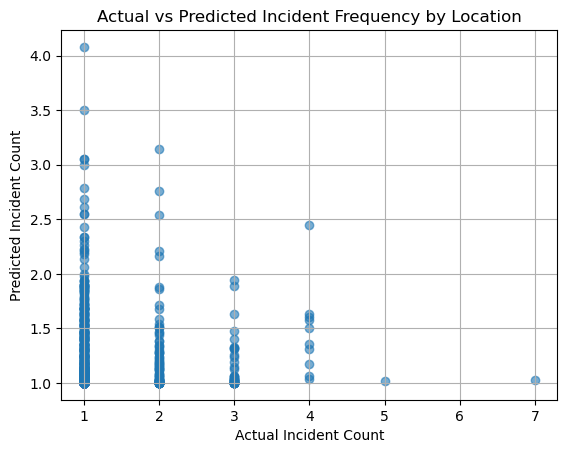

In [642]:
plt.scatter(y_test, y_pred, alpha=0.6)
plt.xlabel("Actual Incident Count")
plt.ylabel("Predicted Incident Count")
plt.title("Actual vs Predicted Incident Frequency by Location")
plt.grid(True)
plt.show()